In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json

from datasets import load_dataset

/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter
 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]


In [3]:

def _fix_fracs(string):
    substrs = string.split("\\frac")
    new_str = substrs[0]
    if len(substrs) > 1:
        substrs = substrs[1:]
        for substr in substrs:
            new_str += "\\frac"
            if substr[0] == "{":
                new_str += substr
            else:
                try:
                    assert len(substr) >= 2
                except:
                    return string
                a = substr[0]
                b = substr[1]
                if b != "{":
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}{" + b + "}" + post_substr
                    else:
                        new_str += "{" + a + "}{" + b + "}"
                else:
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}" + b + post_substr
                    else:
                        new_str += "{" + a + "}" + b
    string = new_str
    return string

def _fix_a_slash_b(string):
    if len(string.split("/")) != 2:
        return string
    a = string.split("/")[0]
    b = string.split("/")[1]
    try:
        a = int(a)
        b = int(b)
        assert string == "{}/{}".format(a, b)
        new_string = "\\frac{" + str(a) + "}{" + str(b) + "}"
        return new_string
    except:
        return string

def _remove_right_units(string):
    # "\\text{ " only ever occurs (at least in the val set) when describing units
    if "\\text{ " in string:
        splits = string.split("\\text{ ")
        assert len(splits) == 2
        return splits[0]
    else:
        return string

def _fix_sqrt(string):
    if "\\sqrt" not in string:
        return string
    splits = string.split("\\sqrt")
    new_string = splits[0] 
    for split in splits[1:]:
        if split[0] != "{":
            a = split[0]
            new_substr = "\\sqrt{" + a + "}" + split[1:]
        else:
            new_substr = "\\sqrt" + split
        new_string += new_substr
    return new_string

def _strip_string(string):
    # linebreaks  
    string = string.replace("\n", "")
    #print(string)

    # remove inverse spaces
    string = string.replace("\\!", "")
    #print(string)

    # replace \\ with \
    string = string.replace("\\\\", "\\")
    #print(string)

    # replace tfrac and dfrac with frac
    string = string.replace("tfrac", "frac")
    string = string.replace("dfrac", "frac")
    #print(string)

    # remove \left and \right
    string = string.replace("\\left", "")
    string = string.replace("\\right", "")
    #print(string)
    
    # Remove circ (degrees)
    string = string.replace("^{\\circ}", "")
    string = string.replace("^\\circ", "")

    # remove dollar signs
    string = string.replace("\\$", "")
    
    # remove units (on the right)
    string = _remove_right_units(string)

    # remove percentage
    string = string.replace("\\%", "")
    string = string.replace("\%", "")

    # " 0." equivalent to " ." and "{0." equivalent to "{." Alternatively, add "0" if "." is the start of the string
    string = string.replace(" .", " 0.")
    string = string.replace("{.", "{0.")
    # if empty, return empty string
    if len(string) == 0:
        return string
    if string[0] == ".":
        string = "0" + string

    # to consider: get rid of e.g. "k = " or "q = " at beginning
    if len(string.split("=")) == 2:
        if len(string.split("=")[0]) <= 2:
            string = string.split("=")[1]

    # fix sqrt3 --> sqrt{3}
    string = _fix_sqrt(string)

    # remove spaces
    string = string.replace(" ", "")

    # \frac1b or \frac12 --> \frac{1}{b} and \frac{1}{2}, etc. Even works with \frac1{72} (but not \frac{72}1). Also does a/b --> \\frac{a}{b}
    string = _fix_fracs(string)

    # manually change 0.5 --> \frac{1}{2}
    if string == "0.5":
        string = "\\frac{1}{2}"

    # NOTE: X/Y changed to \frac{X}{Y} in dataset, but in simple cases fix in case the model output is X/Y
    string = _fix_a_slash_b(string)

    return string

def is_equiv(str1, str2, verbose=False):
    if str1 is None and str2 is None:
        print("WARNING: Both None")
        return True
    if str1 is None or str2 is None:
        return False

    try:
        ss1 = _strip_string(str1)
        ss2 = _strip_string(str2)
        if verbose:
            print(ss1, ss2)
        return ss1 == ss2
    except:
        return str1 == str2

In [4]:

def extract_latex(text):
    start = text.find("#### ") + len("#### ")
    return text[start:].replace(",", "")

def maj_correct(outputs , answer):
    answer = extract_latex(answer)

    output_answers = [extract_latex(output) for output in outputs]
    
    maj_answer = most_frequent(output_answers)
    
    eqiv = is_equiv(answer, maj_answer, verbose=False)

    return eqiv

In [5]:
def get_n_maj_acc(arr, n):
    o = []
    for i in range(1):
        idxs = np.random.choice(arr.shape[-1], n, replace=False)
        maj_correct_all = [maj_correct(arr[j, idxs], test_answers[j]) for j in range(arr.shape[0])]
        # print(maj_correct_all)
        # print(len(maj_correct_all))
        # 1/0
        o.append(np.mean(maj_correct_all))
    return o

In [6]:
import tqdm

In [9]:
X = np.concatenate([np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answers50_seed2.npy"), np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answers50_seed0.npy")], axis=1)
# bon1 = np.array([get_n_maj_acc(X, n) for n in range(1, 101)])

bon1 = []
for n in tqdm.tqdm(range(1, 101)):
    bon1.append(get_n_maj_acc(X, n))


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


In [10]:
X = np.concatenate([np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answers50_seed2.npy"), np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answers50_seed0.npy")], axis=1)
# bon1 = np.array([get_n_maj_acc(X, n) for n in range(1, 101)])

bon2 = []
for n in tqdm.tqdm(range(1, 101)):
    bon2.append(get_n_maj_acc(X, n))

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


In [12]:
bon1 = np.array(bon1)
bon2 = np.array(bon2)

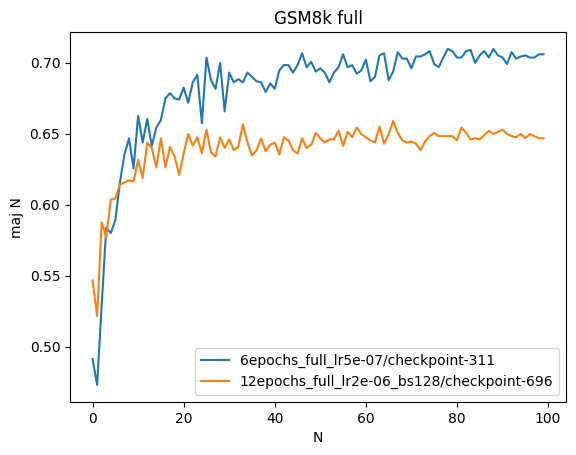

In [14]:
plt.plot(bon1.mean(1), label="6epochs_full_lr5e-07/checkpoint-311")
plt.fill_between(np.arange(100), np.percentile(bon1, 10, axis=-1), np.percentile(bon1, 90, axis=-1), alpha=0.2) 
plt.plot(bon2.mean(1), label="12epochs_full_lr2e-06_bs128/checkpoint-696")
plt.fill_between(np.arange(100), np.percentile(bon2, 10, axis=-1), np.percentile(bon2, 90, axis=-1), alpha=0.2) 
plt.legend()
plt.title("GSM8k full")
plt.xlabel("N")
plt.ylabel("maj N")
plt.savefig("bon.png")

In [15]:
def get_n_mean(arr, n):
    o = []
    for i in range(30):
        idxs = np.random.choice(arr.shape[-1], n, replace=False)
        o.append(arr[:, idxs].max(axis=1).mean())
    return o

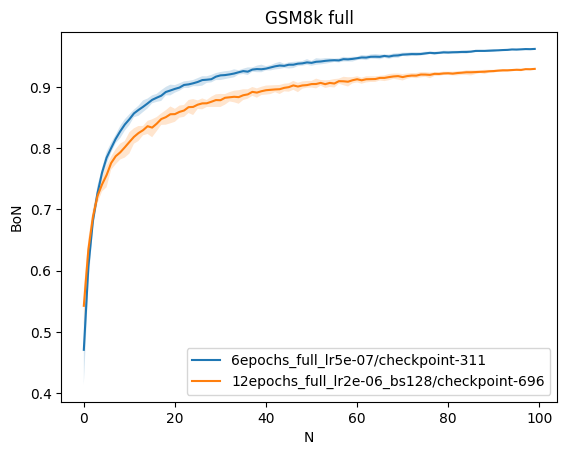

In [17]:
X = np.concatenate([np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answer_types50_seed2.npy")==0, np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answer_types50_seed0.npy")==0], axis=1)
bon1 = np.array([get_n_mean(X, n) for n in range(1, 101)])
X = np.concatenate([np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answer_types50_seed2.npy")==0, np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answer_types50_seed0.npy")==0], axis=1)

bon2 = np.array([get_n_mean(X, n) for n in range(1, 101)])
# bon1  =[]
# for i in range(1, 51):
#     bon1.append(([:, -i:].max(axis=1).mean())
    

# bon12  =[]
# for i in range(1, 51):
#     bon12.append((np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answer_types50_seed2.npy")==0)[:, :i].max(axis=1).mean())

plt.plot(bon1.mean(1), label="6epochs_full_lr5e-07/checkpoint-311")
plt.fill_between(np.arange(100), np.percentile(bon1, 10, axis=-1), np.percentile(bon1, 90, axis=-1), alpha=0.2) 
plt.plot(bon2.mean(1), label="12epochs_full_lr2e-06_bs128/checkpoint-696")
plt.fill_between(np.arange(100), np.percentile(bon2, 10, axis=-1), np.percentile(bon2, 90, axis=-1), alpha=0.2) 
plt.legend()
plt.title("GSM8k full")
plt.xlabel("N")
plt.ylabel("BoN")


plt.savefig("bon.png")

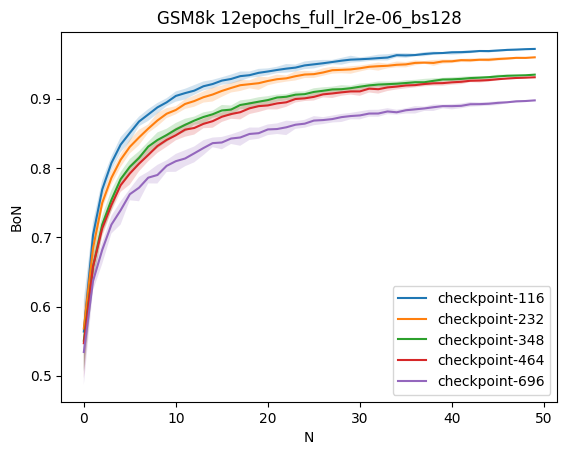

In [18]:

X = np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-116/test_answer_types50_seed2.npy")==0
bon1 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-232/test_answer_types50_seed2.npy")==0
bon2 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-348/test_answer_types50_seed2.npy")==0
bon3 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-464/test_answer_types50_seed2.npy")==0
bon4 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answer_types50_seed2.npy")==0
bon5 = np.array([get_n_mean(X, n) for n in range(1, 51)])
# bon1  =[]
# for i in range(1, 51):
#     bon1.append(([:, -i:].max(axis=1).mean())
    

# bon12  =[]
# for i in range(1, 51):
#     bon12.append((np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answer_types50_seed2.npy")==0)[:, :i].max(axis=1).mean())

plt.plot(bon1.mean(1), label="checkpoint-116")
plt.fill_between(np.arange(50), np.percentile(bon1, 10, axis=-1), np.percentile(bon1, 90, axis=-1), alpha=0.2) 

plt.plot(bon2.mean(1), label="checkpoint-232")
plt.fill_between(np.arange(50), np.percentile(bon2, 10, axis=-1), np.percentile(bon2, 90, axis=-1), alpha=0.2)

plt.plot(bon3.mean(1), label="checkpoint-348")
plt.fill_between(np.arange(50), np.percentile(bon3, 10, axis=-1), np.percentile(bon3, 90, axis=-1), alpha=0.2)

plt.plot(bon4.mean(1), label="checkpoint-464")
plt.fill_between(np.arange(50), np.percentile(bon4, 10, axis=-1), np.percentile(bon4, 90, axis=-1), alpha=0.2)

plt.plot(bon5.mean(1), label="checkpoint-696")
plt.fill_between(np.arange(50), np.percentile(bon5, 10, axis=-1), np.percentile(bon5, 90, axis=-1), alpha=0.2)

plt.xlabel("N")
plt.ylabel("BoN")


plt.title("GSM8k 12epochs_full_lr2e-06_bs128")

plt.legend()
plt.savefig("bon.png")

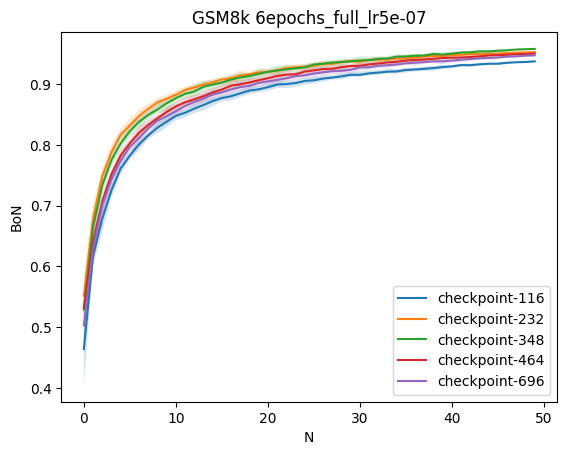

In [19]:

X = np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answer_types50_seed2.npy")==0
bon1 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-623/test_answer_types50_seed2.npy")==0
bon2 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-935/test_answer_types50_seed2.npy")==0
bon3 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-1246/test_answer_types50_seed2.npy")==0
bon4 = np.array([get_n_mean(X, n) for n in range(1, 51)])
X = np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-1558/test_answer_types50_seed2.npy")==0
bon5 = np.array([get_n_mean(X, n) for n in range(1, 51)])
# bon1  =[]
# for i in range(1, 51):
#     bon1.append(([:, -i:].max(axis=1).mean())
    

# bon12  =[]
# for i in range(1, 51):
#     bon12.append((np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-07/checkpoint-311/test_answer_types50_seed2.npy")==0)[:, :i].max(axis=1).mean())

plt.plot(bon1.mean(1), label="checkpoint-116")
plt.fill_between(np.arange(50), np.percentile(bon1, 10, axis=-1), np.percentile(bon1, 90, axis=-1), alpha=0.2) 

plt.plot(bon2.mean(1), label="checkpoint-232")
plt.fill_between(np.arange(50), np.percentile(bon2, 10, axis=-1), np.percentile(bon2, 90, axis=-1), alpha=0.2)

plt.plot(bon3.mean(1), label="checkpoint-348")
plt.fill_between(np.arange(50), np.percentile(bon3, 10, axis=-1), np.percentile(bon3, 90, axis=-1), alpha=0.2)

plt.plot(bon4.mean(1), label="checkpoint-464")
plt.fill_between(np.arange(50), np.percentile(bon4, 10, axis=-1), np.percentile(bon4, 90, axis=-1), alpha=0.2)

plt.plot(bon5.mean(1), label="checkpoint-696")
plt.fill_between(np.arange(50), np.percentile(bon5, 10, axis=-1), np.percentile(bon5, 90, axis=-1), alpha=0.2)

plt.xlabel("N")
plt.ylabel("BoN")


plt.title("GSM8k 6epochs_full_lr5e-07")

plt.legend()
plt.savefig("bon.png")

In [96]:
bon2i = []

for i in range(1, 51):
    bon2i.append((np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answer_types50_seed2.npy")==0)[:, -i:].max(axis=1).mean())
    
bon22 = []

for i in range(1, 51):
    bon22.append((np.load("ckpts/gsm8k_orig_12epochs_full_lr2e-06_bs128/checkpoint-696/test_answer_types50_seed2.npy")==0)[:, :i].max(axis=1).mean())


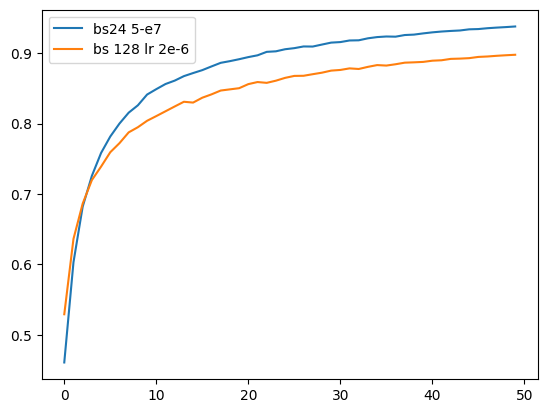

In [102]:
plt.plot(bon1, label="bs24 5-e7")
plt.plot(bon2, label="bs 128 lr 2e-6")
plt.legend()
plt.savefig("bon.png")

In [8]:
dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [4]:
num_memorized_all7 = []
num_correct_different_all7 = []
num_incorrect_all7 = []

ckpts = ["174", "348", "522", "696", "870", "1044"]

for ckpt in ckpts:
    train_correct = (np.load("ckpts/gsm8k_orig_18epochs_full_lr2e-07_bs128/checkpoint-"+ckpt+ "/train_answer_types5_seed2.npy")==0)
    train_samples = (np.load("ckpts/gsm8k_orig_18epochs_full_lr2e-07_bs128/checkpoint-"+ckpt+ "/train_answers5_seed2.npy"))

    num_memorized_ckpt = []
    num_correct_different_ckpt = []
    num_incorrect_ckpt = []

    for input_idx in range(len(train_questions)):
        num_memorized = 0
        num_correct_different = 0
        num_incorrect = 0
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[input_idx].strip():
                    num_memorized+=1
                else:
                    num_correct_different+=1
            else:
                num_incorrect+=1 
        num_memorized_ckpt.append(num_memorized)
        num_correct_different_ckpt.append(num_correct_different)
        num_incorrect_ckpt.append(num_incorrect)
    
    num_memorized_all7.append(num_memorized_ckpt)
    num_correct_different_all7.append(num_correct_different_ckpt)
    num_incorrect_all7.append(num_incorrect_ckpt)
    
num_memorized_all7 = np.array(num_memorized_all7)
num_correct_different_all7 = np.array(num_correct_different_all7)
num_incorrect_all7 = np.array(num_incorrect_all7)

In [9]:
(num_correct_different_all7.max(axis=0)==0).mean()

0.0733306570319818

In [10]:
num_memorized_all5 = []
num_correct_different_all5 = []
num_incorrect_all5 = []

ckpts = ["58", "116", "175", "233", "292", "348"]

for ckpt in ckpts:
    train_correct = (np.load("ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128/checkpoint-"+ckpt+ "/train_answer_types5_seed2.npy")==0)
    train_samples = (np.load("ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128/checkpoint-"+ckpt+ "/train_answers5_seed2.npy"))

    num_memorized_ckpt = []
    num_correct_different_ckpt = []
    num_incorrect_ckpt = []

    for input_idx in range(len(train_questions)):
        num_memorized = 0
        num_correct_different = 0
        num_incorrect = 0
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[input_idx].strip():
                    num_memorized+=1
                else:
                    num_correct_different+=1
            else:
                num_incorrect+=1 
        num_memorized_ckpt.append(num_memorized)
        num_correct_different_ckpt.append(num_correct_different)
        num_incorrect_ckpt.append(num_incorrect)
    
    num_memorized_all5.append(num_memorized_ckpt)
    num_correct_different_all5.append(num_correct_different_ckpt)
    num_incorrect_all5.append(num_incorrect_ckpt)
    
num_memorized_all5 = np.array(num_memorized_all5)
num_correct_different_all5 = np.array(num_correct_different_all5)
num_incorrect_all5 = np.array(num_incorrect_all5)

In [21]:
num_memorized_all1 = []
num_correct_different_all1 = []
num_incorrect_all1 = []

ckpts = ["311", "623", "935", "1246", "1558", "1866"]

for ckpt in ckpts:
    train_correct = (np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-05/checkpoint-"+ckpt+ "/train_answer_types5_seed2.npy")==0)
    train_samples = (np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-05/checkpoint-"+ckpt+ "/train_answers5_seed2.npy"))

    num_memorized_ckpt = []
    num_correct_different_ckpt = []
    num_incorrect_ckpt = []

    for input_idx in range(len(train_questions)):
        num_memorized = 0
        num_correct_different = 0
        num_incorrect = 0
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[input_idx].strip():
                    num_memorized+=1
                else:
                    num_correct_different+=1
            else:
                num_incorrect+=1 
        num_memorized_ckpt.append(num_memorized)
        num_correct_different_ckpt.append(num_correct_different)
        num_incorrect_ckpt.append(num_incorrect)
    
    num_memorized_all1.append(num_memorized_ckpt)
    num_correct_different_all1.append(num_correct_different_ckpt)
    num_incorrect_all1.append(num_incorrect_ckpt)
    
num_memorized_all1 = np.array(num_memorized_all1)
num_correct_different_all1 = np.array(num_correct_different_all1)
num_incorrect_all1 = np.array(num_incorrect_all1)

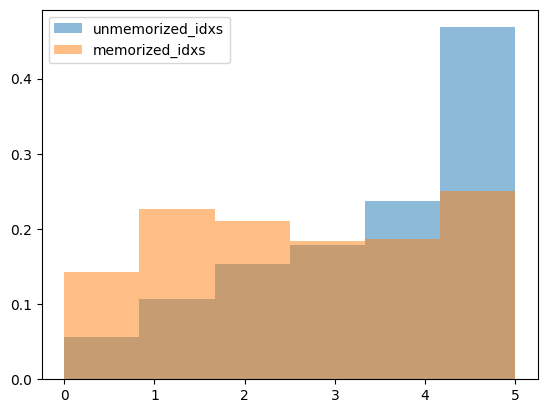

In [22]:


correct_idxs = np.where((num_memorized_all5+num_correct_different_all5).max(axis=0) > 2)

unmemorized_idxs = np.where(num_correct_different_all5.max(axis=0) >2)[0]

memorized_idxs = np.setdiff1d(correct_idxs, unmemorized_idxs)

plt.hist(num_correct_different_all1.max(axis=0)[unmemorized_idxs], alpha = 0.5, bins = 6, density = True, label = "unmemorized_idxs")
plt.hist(num_correct_different_all1.max(axis=0)[memorized_idxs]  , alpha = 0.5, bins = 6, density = True, label = "memorized_idxs")

plt.legend()

plt.savefig("delete.png")


In [23]:
correct_idxs1 = np.where((num_memorized_all1+num_correct_different_all1).max(axis=0) > 2)
unmemorized_idxs1 = np.where(num_correct_different_all1.max(axis=0) >2)[0]
memorized_idxs1 = np.setdiff1d(correct_idxs1, unmemorized_idxs1)

In [31]:
len(np.intersect1d(memorized_idxs1, memorized_idxs))/len(memorized_idxs)

0.4661716171617162

In [32]:
len(memorized_idxs1)/(len(memorized_idxs1)+len(unmemorized_idxs1))

0.29364864864864865

In [29]:
len(unmemorized_idxs)

6198

In [34]:

for i in range(1, 6):
    print((num_correct_different_all7[:i].max(axis=0)>2).mean())
    print((num_correct_different_all5[:i].max(axis=0)>2).mean())
    print("")

# (num_correct_different_all5[:i].max(axis=0)>2).mean()

0.3535394085374013
0.49605245550649

0.5126455238859896
0.6894152281546903

0.5982871671350194
0.7824167001204335

0.6465944065301753
0.8180115080958116

0.6740264953833802
0.8265756724207146



In [35]:
test_accs_all1 = []
pass5_all1 = []
ckpts = ["311", "623", "935", "1246", "1558", "1866"]

for ckpt in ckpts:
    test_accs = (np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-05/checkpoint-"+ckpt+ "/test_answer_types5_seed2.npy")==0)
    pass5_all1.append(test_accs.max(axis=-1))
    test_accs_all1.append(test_accs)

test_accs_all1 = np.array(test_accs_all1)
pass5_all1 = np.array(pass5_all1)
print(test_accs_all1)
print(pass5_all1)

[[[False False False False False]
  [ True  True  True  True False]
  [False False False False False]
  ...
  [False False False False False]
  [False False  True False False]
  [False False False False False]]

 [[ True False False False  True]
  [False False  True False False]
  [False False False False False]
  ...
  [False  True False False  True]
  [False False False False False]
  [ True False  True  True  True]]

 [[False False False False False]
  [ True  True  True  True  True]
  [False False False False False]
  ...
  [False False False False False]
  [False False False False False]
  [ True  True False  True  True]]

 [[ True  True  True False False]
  [ True  True  True  True False]
  [False False False False False]
  ...
  [False False False False False]
  [False False False False False]
  [ True  True  True  True  True]]

 [[ True  True False False False]
  [ True  True  True False  True]
  [False False False False False]
  ...
  [False  True  True False False]
  [False F

In [36]:
test_accs_all5 = []
pass5_all5 = []
ckpts = ["58", "116", "175", "233", "292", "348"]

for ckpt in ckpts:
    test_accs = (np.load("ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128/checkpoint-"+ckpt+ "/test_answer_types5_seed2.npy")==0)
    pass5_all5.append(test_accs.max(axis=-1))
    test_accs_all5.append(test_accs)

test_accs_all5 = np.array(test_accs_all5)
pass5_all5 = np.array(pass5_all5)
print(test_accs_all5)
print(pass5_all5)

[[[ True  True  True False False]
  [ True  True  True False  True]
  [False False False False False]
  ...
  [ True  True  True False  True]
  [False False False False False]
  [False False False  True  True]]

 [[False  True  True False False]
  [False  True False  True False]
  [False False False False False]
  ...
  [ True False  True False False]
  [False False  True False False]
  [ True  True  True  True  True]]

 [[ True  True  True  True False]
  [ True  True False  True  True]
  [False False False False False]
  ...
  [False  True False  True False]
  [False False False False False]
  [ True  True False False  True]]

 [[ True  True  True False False]
  [ True  True  True  True  True]
  [False False False False False]
  ...
  [False False False False False]
  [False False False False False]
  [ True  True  True False  True]]

 [[ True  True  True  True  True]
  [ True  True  True False  True]
  [False False False False False]
  ...
  [False False False False False]
  [ True F

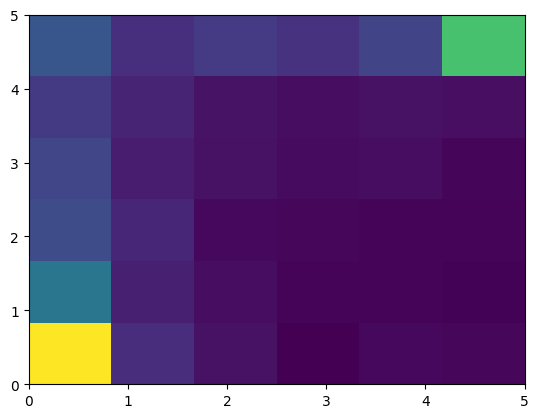

In [39]:
plt.hist2d(test_accs_all1[-1].sum(axis=1), test_accs_all5[-1].sum(axis=1), bins = 6)
plt.savefig("delete.png")

In [49]:
dataset = load_dataset("gsm8k", "main")
test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])

In [54]:
num_newlines = [test_answers[i].count("\n") for i in range(len(test_answers))]
num_newlines = np.array(num_newlines)

In [41]:
np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 5))[0]

array([   6,   11,   26,   47,   67,   68,   92,  171,  207,  219,  230,
        242,  247,  306,  308,  316,  348,  356,  370,  391,  397,  436,
        444,  465,  489,  501,  509,  516,  518,  522,  537,  547,  559,
        569,  571,  581,  585,  588,  609,  612,  616,  627,  663,  668,
        669,  681,  693,  697,  728,  739,  775,  785,  800,  853,  868,
        878,  888,  900,  961,  972,  994, 1078, 1079, 1084, 1093, 1100,
       1101, 1111, 1131, 1172, 1237, 1278, 1279, 1285, 1289])

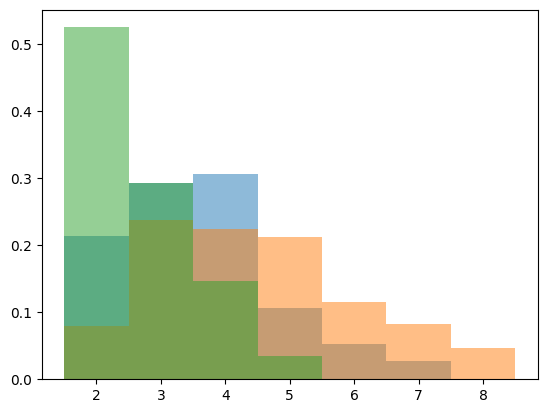

In [59]:
plt.hist(num_newlines[np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 5))[0]], bins = np.arange(2, 10)-0.5, alpha = 0.5, density = True, label = "0/5") 
plt.hist(num_newlines[np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 0))[0]], bins = np.arange(2, 10)-0.5, alpha = 0.5, density = True, label = "0/5") 
plt.hist(num_newlines[np.where((test_accs_all1[-1].sum(axis=1) == 5)*(test_accs_all5[-1].sum(axis=1) == 5))[0]], bins = np.arange(2, 10)-0.5, alpha = 0.5, density = True, label = "0/5") 


plt.savefig("delete.png")

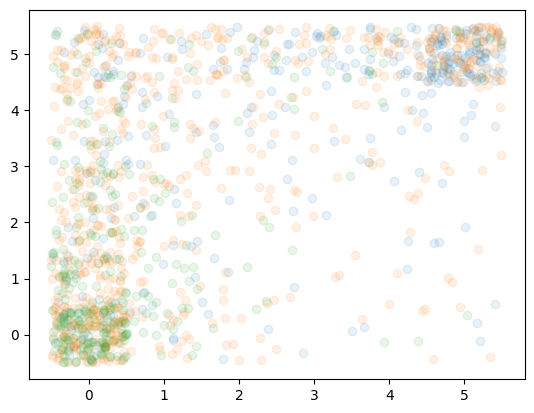

In [67]:
subsample_idxs = np.where(num_newlines <= 2)[0]
plt.scatter(test_accs_all1[-1].sum(axis=1)[subsample_idxs]+np.random.uniform(-0.5, 0.5, len(subsample_idxs)), test_accs_all5[-1].sum(axis=1)[subsample_idxs]+np.random.uniform(-0.5, 0.5, len(subsample_idxs)), alpha=0.1)

subsample_idxs = np.where((num_newlines > 2)*(num_newlines <= 4))[0]
plt.scatter(test_accs_all1[-1].sum(axis=1)[subsample_idxs]+np.random.uniform(-0.5, 0.5, len(subsample_idxs)), test_accs_all5[-1].sum(axis=1)[subsample_idxs]+np.random.uniform(-0.5, 0.5, len(subsample_idxs)), alpha=0.1)

subsample_idxs = np.where(num_newlines > 4)[0]
plt.scatter(test_accs_all1[-1].sum(axis=1)[subsample_idxs]+np.random.uniform(-0.5, 0.5, len(subsample_idxs)), test_accs_all5[-1].sum(axis=1)[subsample_idxs]+np.random.uniform(-0.5, 0.5, len(subsample_idxs)), alpha=0.1)



plt.savefig("delete.png")

In [50]:
test_answers[np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 5))[0]]

array(['If Seattle has 20 sheep, Charleston has 4 * 20 sheep = <<20*4=80>>80 sheep\nToulouse has twice as many sheep as Charleston, which is 2 * 80 sheep = <<2*80=160>>160 sheep\nTogether, the three has 20 sheep + 160 sheep + 80 sheep = <<20+160+80=260>>260 sheep\n#### 260',
       'The total charge for the doughnuts was 3 x $68 = $<<3*68=204>>204.\nThe total charge for the mini cupcakes was 2 x $80 = $<<2*80=160>>160.\nThe total charge for the mini cheesecakes was 6 x $55 = $<<6*55=330>>330.\nTherefore the total amount Toula paid for the pastries was $204 + $160 + $330 = $<<204+160+330=694>>694.\n#### 694',
       '3 * (16.50 + 22.50 + 42) = $<<3*(16.50+22.50+42)=243>>243\nMishka spent $243 on clothing.\n#### 243',
       'He bought 200 / 40 = <<200/40=5>>5 blue ties\nSo he bought 5 * 2 = <<5*2=10>>10 red ties\nEach red tie cost $40 * .5 = $<<40*.5=20>>20 more than blue ties\nSo they each cost $40 + $20 = $<<40+20=60>>60\nSo he spent $60 * 10 = $<<60*10=600>>600 on red ties\nSo he spe

In [52]:
(np.load("ckpts/gsm8k_orig_18epochs_full_lr2e-07_bs128/checkpoint-"+"1044"+ "/test_answers5_seed2.npy"))[np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 5))[0]]

array([[' Charleston has 4 * 20 sheep = <<4*20=80>>80 sheep.\nToulouse has 2 * 80 sheep = <<2*80=160>>160 sheep.\nTogether, they have 160 sheep + 80 sheep + 20 sheep = <<160+80+20=260>>260 sheep\n#### 260',
        " Charleston has 4 times as many sheep as Seattle's 20 sheep, a total of 4 * 20 = <<4*20=80>>80 sheep\nToulouse has twice as many sheep as Charleston's 80 sheep, a total of 2 * 80 = <<2*80=160>>160 sheep\nAltogether, Toulouse, Charleston, and Seattle have 20 + 80 + 160 = <<20+80+160=260>>260 sheep\n#### 260",
        ' Charleston has 20*4=<<20*4=80>>80 sheep.\nToulouse has 80*2=<<80*2=160>>160 sheep.\nTogether, the three cities have 160+80+20 = <<160+80+20=260>>260 sheep.\n#### 260',
        " Charleston has 4 times as many sheep as Seattle's 20 sheep, a total of 4 * 20 = <<4*20=80>>80 sheep\nToulouse has twice as many sheep as Charleston's 80 sheep, a total of 2 * 80 = <<2*80=160>>160 sheep\nAll together, the three cities have 20 sheep from Seattle + 160 sheep from Toulouse

In [46]:
(np.load("ckpts/gsm8k_orig_6epochs_full_lr2e-05_bs128/checkpoint-"+"348"+ "/test_answers5_seed2.npy"))[np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 5))[0]]

array([[' Charleston has 4*20=<<4*20=80>>80 sheep.\nToulouse has 2*80=<<2*80=160>>160 sheep.\nTogether, they have 20+80+160=<<20+80+160=260>>260 sheep\n#### 260',
        ' Charleston has 4*20=<<4*20=80>>80 sheep.\nToulouse has 2*80=<<2*80=160>>160 sheep.\nTogether, they have 20+80+160=<<20+80+160=260>>260 sheep\n#### 260',
        ' Charleston has 4 * 20 = <<4*20=80>>80 sheep.\nToulouse has 2 * 80 = <<2*80=160>>160 sheep.\nTogether, they have 20 + 80 + 160 = <<20+80+160=260>>260 sheep.\n#### 260',
        ' Charleston has 4*20=<<4*20=80>>80 sheep.\nToulouse has 2*80=<<2*80=160>>160 sheep.\nTogether, they have 160+80+20=<<160+80+20=260>>260 sheep\n#### 260',
        ' Since Charleston has 4 times as many sheep as Seattle, it has 4*20=<<4*20=80>>80 sheep.\nTogether, Seattle and Charleston have 20+80=<<20+80=100>>100 sheep.\nSince Toulouse has twice as many sheep as Charleston, it has 2*80=<<2*80=160>>160 sheep.\nTogether, Toulouse, Charleston, and Seattle have 160+100=<<160+100=260>>260

In [48]:
(np.load("ckpts/gsm8k_orig_6epochs_full_lr5e-05/checkpoint-"+"1866"+ "/test_answers5_seed2.npy"))[np.where((test_accs_all1[-1].sum(axis=1) == 0)*(test_accs_all5[-1].sum(axis=1) == 5))[0]]

array([[' If Seattle has 20 sheep, then Charleston has 4*20=<<20*4=80>>80 sheep\nTogether, Seattle and Charleston have 80+20=<<80+20=100>>100 sheep\nToulouse has 2*100=<<2*100=200>>200 sheep\nTogether, the three have 200+100=<<200+100=300>>300 sheep\n#### 300',
        ' If Charleston has 4 times as many sheep as Seattle, then the number of sheep in Charleston is 4*20=<<4*20=80>>80\nTogether, Charleston and Seattle have 80+20=<<80+20=100>>100 sheep\nToulouse has 2*100=<<2*100=200>>200 sheep\nTogether, the three have 200+100=<<200+100=300>>300 sheep\n#### 300',
        ' If Charleston has 4 times as many sheep as Seattle, then it has 4*20 = <<4*20=80>>80 sheep.\nTogether, Seattle and Charleston have 80+20 = <<80+20=100>>100 sheep.\nToulouse has 2*100 = <<2*100=200>>200 sheep\nTogether, the three have 200+100 = <<200+100=300>>300 sheep.\n#### 300',
        ' If Seattle has 20 sheep, then Charleston has 4*20=<<20*4=80>>80 sheep\nTogether, Charleston and Seattle have 80+20=<<80+20=100>>100